### CISC 601 - Scientific Computing II
* Assignment: Artificial Neural Network (ANN) for activity recognition
* Data set and problem description: https://www.neuraldesigner.com/learning/examples/activity-recognition#DataSet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
# load data:
data = pd.read_csv('activity_recognition.csv', delimiter=';')
print(data.info())
X = data.iloc[:, :-1]
Y = pd.get_dummies(data['label'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 562 entries, tBodyAcc_mean_X to label
dtypes: float64(561), object(1)
memory usage: 44.2+ MB
None


In [3]:
# select most important features:
n_features = 50
feat_importances = []
for i in Y.columns:
    clf = GradientBoostingClassifier()
    clf.fit(X, Y.loc[:, i])
    print('ran GBM done with target variable: ', i)
    feat_importances.append(pd.Series(clf.feature_importances_, index=X.columns))
features = pd.concat(feat_importances, axis=1).sum(axis=1).sort_values(ascending=False)[:n_features]

ran GBM done with target variable:  LAYING
ran GBM done with target variable:  SITTING
ran GBM done with target variable:  STANDING
ran GBM done with target variable:  WALKING
ran GBM done with target variable:  WALKING_DOWNSTAIRS
ran GBM done with target variable:  WALKING_UPSTAIRS


In [4]:
# prepare data set:
X = X[features.index]
df = pd.concat([X, Y], axis=1)
X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, Y, test_size=0.4, random_state=123)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=0.5, random_state=123)

In [11]:
# define ANN:
def ann(indput_dim, output_dim, dropout=0.2):
    model = Sequential([
        Dense(units=100, kernel_initializer='uniform', input_dim=indput_dim, activation='tanh'),
        Dropout(dropout),
        Dense(units=100, kernel_initializer='uniform', activation='tanh'),
        Dropout(dropout),
        Dense(units=25, kernel_initializer='uniform', activation='tanh'),
        Dropout(dropout),
        Dense(units=15, kernel_initializer='uniform', activation='tanh'),
        Dropout(dropout),
        Dense(output_dim, kernel_initializer='uniform', activation='softmax')
    ])
    return model

In [12]:
# fit model:
filepath = 'weights.best.hdf5'
checkpoints = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]
clf = ann(
    indput_dim=X_train.shape[1], 
    output_dim=Y_train.shape[1], 
    dropout=0.2
)
clf.compile(
    optimizer=Adam(lr = 1e-3), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
history = clf.fit(
    x=X_train, 
    y=Y_train, 
    validation_data=(X_val,Y_val),
    callbacks=checkpoints,
    batch_size=10, 
    epochs=200, 
    verbose=1
)

Train on 6179 samples, validate on 2060 samples
Epoch 1/200
6179/6179 [==============================] - 5s 844us/step - loss: 0.2738 - acc: 0.8653 - val_loss: 0.1988 - val_acc: 0.8837

Epoch 00001: val_loss improved from inf to 0.19881, saving model to weights.best.hdf5
Epoch 2/200
6179/6179 [==============================] - 4s 628us/step - loss: 0.1953 - acc: 0.8989 - val_loss: 0.1577 - val_acc: 0.9189

Epoch 00002: val_loss improved from 0.19881 to 0.15774, saving model to weights.best.hdf5
Epoch 3/200
6179/6179 [==============================] - 4s 721us/step - loss: 0.1662 - acc: 0.9187 - val_loss: 0.1386 - val_acc: 0.9310

Epoch 00003: val_loss improved from 0.15774 to 0.13861, saving model to weights.best.hdf5
Epoch 4/200
6179/6179 [==============================] - 4s 685us/step - loss: 0.1555 - acc: 0.9275 - val_loss: 0.1298 - val_acc: 0.9434

Epoch 00004: val_loss improved from 0.13861 to 0.12978, saving model to weights.best.hdf5
Epoch 5/200
6179/6179 [=====================

Epoch 40/200
6179/6179 [==============================] - 3s 449us/step - loss: 0.1112 - acc: 0.9558 - val_loss: 0.0868 - val_acc: 0.9637

Epoch 00040: val_loss did not improve from 0.08119
Epoch 41/200
6179/6179 [==============================] - 3s 503us/step - loss: 0.1090 - acc: 0.9564 - val_loss: 0.0837 - val_acc: 0.9647

Epoch 00041: val_loss did not improve from 0.08119
Epoch 42/200
6179/6179 [==============================] - 3s 528us/step - loss: 0.1132 - acc: 0.9547 - val_loss: 0.0846 - val_acc: 0.9638

Epoch 00042: val_loss did not improve from 0.08119
Epoch 43/200
6179/6179 [==============================] - 3s 517us/step - loss: 0.1090 - acc: 0.9569 - val_loss: 0.0859 - val_acc: 0.9629

Epoch 00043: val_loss did not improve from 0.08119
Epoch 44/200
6179/6179 [==============================] - 4s 595us/step - loss: 0.1077 - acc: 0.9574 - val_loss: 0.0838 - val_acc: 0.9632

Epoch 00044: val_loss did not improve from 0.08119
Epoch 45/200
6179/6179 [==========================

6179/6179 [==============================] - 3s 506us/step - loss: 0.1053 - acc: 0.9584 - val_loss: 0.0828 - val_acc: 0.9648

Epoch 00082: val_loss did not improve from 0.07698
Epoch 83/200
6179/6179 [==============================] - 5s 812us/step - loss: 0.1024 - acc: 0.9584 - val_loss: 0.0799 - val_acc: 0.9673

Epoch 00083: val_loss did not improve from 0.07698
Epoch 84/200
6179/6179 [==============================] - 6s 1ms/step - loss: 0.1020 - acc: 0.9596 - val_loss: 0.0798 - val_acc: 0.9663

Epoch 00084: val_loss did not improve from 0.07698
Epoch 85/200
6179/6179 [==============================] - 11s 2ms/step - loss: 0.1039 - acc: 0.9584 - val_loss: 0.0802 - val_acc: 0.9672

Epoch 00085: val_loss did not improve from 0.07698
Epoch 86/200
6179/6179 [==============================] - 11s 2ms/step - loss: 0.1041 - acc: 0.9580 - val_loss: 0.0812 - val_acc: 0.9676

Epoch 00086: val_loss did not improve from 0.07698
Epoch 87/200
6179/6179 [==============================] - 11s 2ms/s

6179/6179 [==============================] - 3s 476us/step - loss: 0.1014 - acc: 0.9596 - val_loss: 0.0779 - val_acc: 0.9676

Epoch 00125: val_loss did not improve from 0.07582
Epoch 126/200
6179/6179 [==============================] - 3s 506us/step - loss: 0.0988 - acc: 0.9599 - val_loss: 0.0782 - val_acc: 0.9676

Epoch 00126: val_loss did not improve from 0.07582
Epoch 127/200
6179/6179 [==============================] - 3s 509us/step - loss: 0.1006 - acc: 0.9602 - val_loss: 0.0795 - val_acc: 0.9679

Epoch 00127: val_loss did not improve from 0.07582
Epoch 128/200
6179/6179 [==============================] - 3s 544us/step - loss: 0.0999 - acc: 0.9602 - val_loss: 0.0778 - val_acc: 0.9689

Epoch 00128: val_loss did not improve from 0.07582
Epoch 129/200
6179/6179 [==============================] - 3s 445us/step - loss: 0.1027 - acc: 0.9591 - val_loss: 0.0772 - val_acc: 0.9689

Epoch 00129: val_loss did not improve from 0.07582
Epoch 130/200
6179/6179 [==============================] - 


Epoch 00167: val_loss did not improve from 0.07509
Epoch 168/200
6179/6179 [==============================] - 4s 577us/step - loss: 0.0997 - acc: 0.9606 - val_loss: 0.0817 - val_acc: 0.9667

Epoch 00168: val_loss did not improve from 0.07509
Epoch 169/200
6179/6179 [==============================] - 3s 488us/step - loss: 0.0996 - acc: 0.9601 - val_loss: 0.0787 - val_acc: 0.9689

Epoch 00169: val_loss did not improve from 0.07509
Epoch 170/200
6179/6179 [==============================] - 3s 423us/step - loss: 0.0995 - acc: 0.9585 - val_loss: 0.0812 - val_acc: 0.9664

Epoch 00170: val_loss did not improve from 0.07509
Epoch 171/200
6179/6179 [==============================] - 3s 486us/step - loss: 0.0996 - acc: 0.9598 - val_loss: 0.0778 - val_acc: 0.9687

Epoch 00171: val_loss did not improve from 0.07509
Epoch 172/200
6179/6179 [==============================] - 3s 509us/step - loss: 0.0988 - acc: 0.9614 - val_loss: 0.0798 - val_acc: 0.9676

Epoch 00172: val_loss did not improve from 0

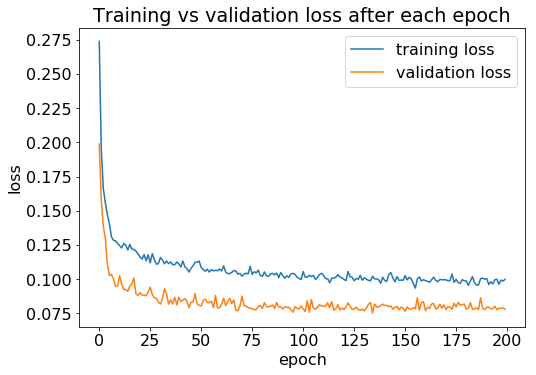

In [13]:
# plot history of training and validation loss:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.rcParams.update({'figure.figsize': [8, 5.5], 'font.size': 16})
plt.plot(train_loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training vs validation loss after each epoch')
plt.legend()
plt.show()

In [14]:
# predict
clf.load_weights('weights.best.hdf5')
Y_pred_train = clf.predict_classes(X_train, verbose=1)
Y_pred_val = clf.predict_classes(X_val, verbose=1)
Y_pred_test = clf.predict_classes(X_test, verbose=1)

2060/2060 [==============================] - 0s 124us/step


In [15]:
# transform Y_true and Y_pred to classes:
classes = {}
for i in range(len(Y.columns)):
    classes[i] = Y.columns[i]
Y_pred_train_classes = [classes[i] for i in Y_pred_train]
Y_pred_val_classes = [classes[i] for i in Y_pred_val]
Y_pred_test_classes = [classes[i] for i in Y_pred_test]
Y_train_classes = Y_train[Y_train==1].stack().reset_index().drop(0,1)['level_1']
Y_val_classes = Y_val[Y_val==1].stack().reset_index().drop(0,1)['level_1']
Y_test_classes = Y_test[Y_test==1].stack().reset_index().drop(0,1)['level_1']

In [16]:
# evaluate accuracies:
train_accuracy = accuracy_score(Y_train_classes, Y_pred_train_classes)
val_accuracy = accuracy_score(Y_val_classes, Y_pred_val_classes)
test_accuracy = accuracy_score(Y_test_classes, Y_pred_test_classes)
print('training accuracy: ', train_accuracy)
print('validation accuracy: ', val_accuracy)
print('test accuracy: ', test_accuracy)

training accuracy:  0.9237740734746723
validation accuracy:  0.9063106796116505
test accuracy:  0.908252427184466
